In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

2025-05-12 05:32:15.648884: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 05:32:15.678703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 05:32:15.678734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 05:32:15.679629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 05:32:15.684794: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 05:32:15.685758: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 10
N_ROWS = 10
N_COLS = 5
N_ROWS_RX = 1
N_COLS_RX = 1
PI = np.pi
RIS_ROWS = RIS_COLS = 40
# RIS1_LOC = [-171, -88, 49]
RIS1_LOC = [-41, -28, 39]
# RIS2_LOC = [-171, 128, 29]
TX_LOC = [41,4,59]
# TX_LOC = [41,8,49]
UE_Z = 1.83
# TX_LOC = [180,200,75]
# RX0_LOC = [-291,60, UE_Z]
RX0_LOC = [-21,60, UE_Z]
RX1_LOC = [50,56, UE_Z]
RX2_LOC = [-25,6, UE_Z]
# RX3_LOC = [-200,0, UE_Z]
RX3_LOC = [-60,0, UE_Z]
# RX4_LOC = [-245,-52, UE_Z]
RX4_LOC = [-45,-52, UE_Z]
RX5_LOC = [62,-52, UE_Z]
RX6_LOC = [0,-10, UE_Z]
# RX7_LOC = [-134,97, UE_Z]
RX7_LOC = [4,97, UE_Z]
# RX8_LOC = [183,-131, UE_Z]
RX8_LOC = [23,-31, UE_Z]
# RX9_LOC = [-1, 123, UE_Z]
RX9_LOC = [-1, 13, UE_Z]
RX0_LOC_tf = tf.constant([-291, 60, UE_Z], dtype=tf.float32)
RX1_LOC_tf = tf.constant([50, 56, UE_Z], dtype=tf.float32)
RX2_LOC_tf = tf.constant([-25, 56, UE_Z], dtype=tf.float32)
RX3_LOC_tf = tf.constant([-200, 0, UE_Z], dtype=tf.float32)
RX4_LOC_tf = tf.constant([-245, -52, UE_Z], dtype=tf.float32)
RX5_LOC_tf = tf.constant([62, -52, UE_Z], dtype=tf.float32)
RX6_LOC_tf = tf.constant([0, -10, UE_Z], dtype=tf.float32)
RX7_LOC_tf = tf.constant([-134, 97, UE_Z], dtype=tf.float32)
RX8_LOC_tf = tf.constant([183, -131, UE_Z], dtype=tf.float32)
RX9_LOC_tf = tf.constant([-1, 123, UE_Z], dtype=tf.float32)

# rx_pos = [RX0_LOC, RX1_LOC, RX2_LOC, RX3_LOC, RX4_LOC, \
#           RX5_LOC, RX6_LOC, RX7_LOC, RX8_LOC, RX9_LOC]
rx_pos = [[np.random.randint(-40, 40), np.random.randint(-40, 40), UE_Z] for i in range(N_RX)]
rx_pos_tens = [tf.convert_to_tensor(i) for i in rx_pos]
# rx_pos = [[np.random.randint(-150, 150), np.random.randint(-150, 150), 1.83] for _ in range(10)]

def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC
scene.synthetic_array = True
scene.bandwidth = BW
# print(rx_pos)

In [3]:
power_watts = 10
power_dbm = 10 * np.log10(power_watts / 10**-3)
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="iso",
                             polarization="V")
#tr38901

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS_RX,
                             num_cols=N_COLS_RX,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 power_dbm=power_dbm)

scene.add(tx)

for i in range(N_RX):
    scene.remove(f"rx-{i}")
    rx = sionna.rt.Receiver(name = f"rx-{i}",
                            position = rx_pos[i])
    scene.add(rx)

# RIS_W_M = round(float((0.5*scene.wavelength) * RIS_ROWS), 2)
# print(RIS_W_M)
#ang Z, ang Y, ang X rot
ris_user_p1 = 3
RIS_ROT = [-PI/2,0,0]
ris1 = RIS(name="ris1",
          position=RIS1_LOC,
          look_at = (tx.position + rx_pos_tens[ris_user_p1])/2,
          num_rows=RIS_ROWS,
          num_cols=RIS_COLS,
          color=[1,0.5,0],
          num_modes = 1)

sources = [tx.position, tx.position, tx.position, tx.position, tx.position, 
           tx.position, tx.position, tx.position, tx.position, tx.position]
targets = [RX0_LOC_tf, RX1_LOC_tf, RX2_LOC_tf, RX3_LOC_tf, RX4_LOC_tf, 
           RX5_LOC_tf, RX6_LOC_tf, RX7_LOC_tf, RX8_LOC_tf, RX9_LOC_tf]
scene.add(ris1)
# ris1.phase_gradient_reflector(tx.position, rx_pos_tens[7])
ris1.focusing_lens(tx.position, rx_pos_tens[ris_user_p1])
# ris1.amplitude_profile.mode_powers = [10]

In [4]:
print(tx.position)
print(RX0_LOC_tf)

tf.Tensor([41.  4. 59.], shape=(3,), dtype=float32)
tf.Tensor([-291.     60.      1.83], shape=(3,), dtype=float32)


In [5]:
paths  = scene.compute_paths(max_depth = 6, diffraction=True, ris=True)

In [6]:
bird_cam = sionna.rt.Camera("bird_cam", position = [-5,-10,750], look_at = [-5,-10,0])
scene.add(bird_cam)
# scene.render(camera = "bird_cam", paths = paths, num_samples = 64)
scene.render_to_file(camera = bird_cam, filename="RIS_MIMO.png", num_samples = 64)

In [7]:
a, tau = paths.cir()
#tau [batch_size, num_rx,num_tx, max_num_paths]
#a [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_timesteps]

Text(0, 0.5, '$|a|$')

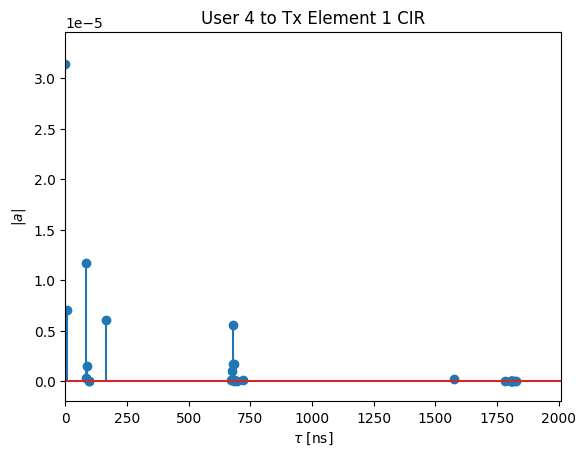

In [8]:
rx_num = ris_user_p1
tx_ant = 0
#tau [batch_size, num_rx,num_tx, max_num_paths]
t = tau[0, rx_num, 0, :] / 1e-9
t = np.concatenate([(0,), t, (np.max(t)*1.1,)])
a_abs = np.abs(a)[0, rx_num, 0, 0, tx_ant, :, 0]
a_max = np.max(a_abs)
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])
plt.figure()
plt.title(f"User {rx_num + 1} to Tx Element {tx_ant + 1} CIR")
plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max * 1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [9]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs).astype(np.float32)
H = sionna.channel.cir_to_ofdm_channel(sweep_freqs, a, tau, normalize=True)
# h_f ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size], tf.complex) 
print(H.shape)
H = H.numpy()
abs_H_FS = np.abs(H)

(1, 10, 1, 1, 50, 1, 1000)


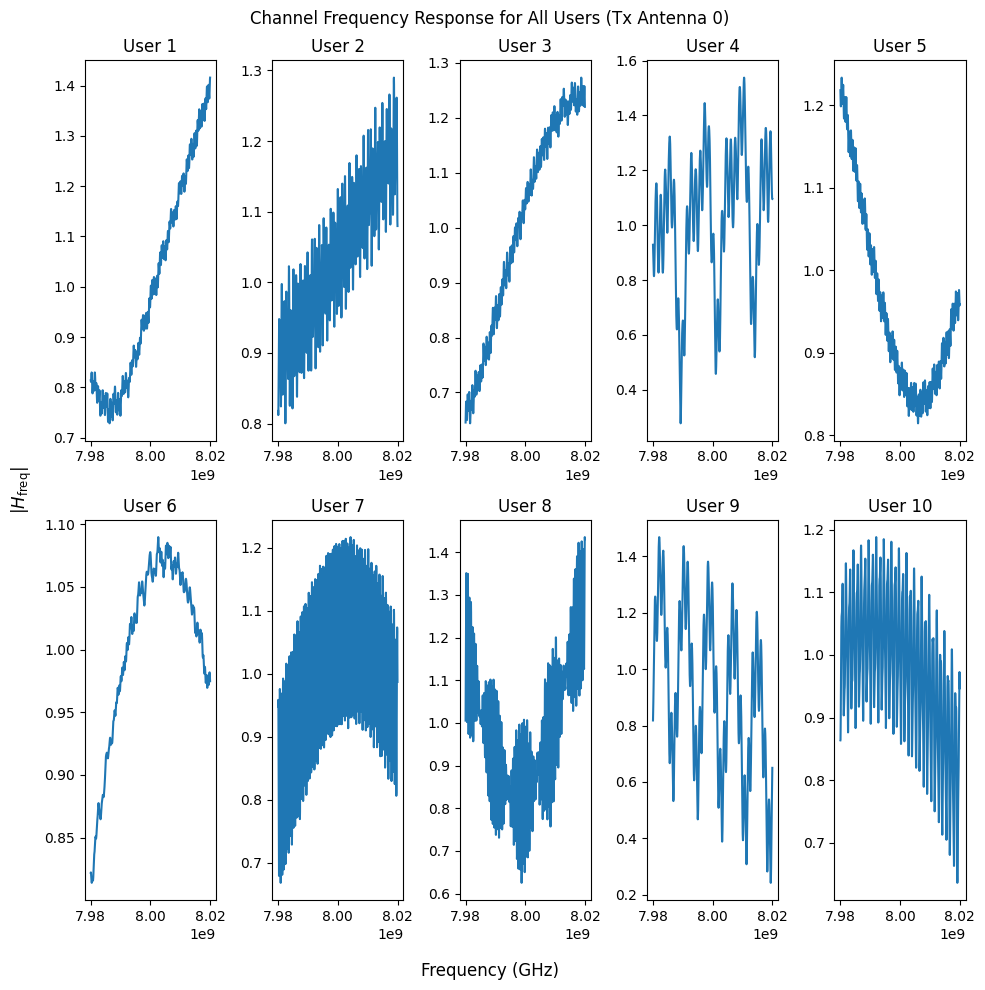

In [10]:
fig1, axs1 = plt.subplots(2,5, figsize = (10,10))
axs1 = axs1.flatten()

for i, ax in enumerate(axs1):
    ax.plot(sweep_freqs, abs_H_FS[0, i, 0, 0, tx_ant, 0, :])
    ax.set_title(f"User {i + 1}")
    # ax.set_xlabel("Frequency (GHz)")
    # ax.set_ylabel(r"|$h_\text{freq}$|")

fig1.supxlabel("Frequency (GHz)")
fig1.supylabel(r"|$H_\text{freq}$|")
fig1.suptitle("Channel Frequency Response for All Users (Tx Antenna 0)")
plt.tight_layout()
plt.show()

In [11]:
# bird_cam = sionna.rt.Camera("bird_cam", position = [-5,-10,950], look_at = [-5,-10,0])
# bird_cam = sionna.rt.Camera("bird_cam", position = [-5,-10,450], look_at = RIS_LOC)
# scene.add(bird_cam)
# scene.render(camera = "bird_cam", paths = paths, num_samples = 64)
# scene.render_to_file(camera = bird_cam, filename="mu_mimo_radiomap_noZF.png", paths = paths, radio_map = rm, num_samples = 64)

In [12]:
# scene.preview()

Text(0.5, 1.0, 'User Locations in Z = 1.83 Plane')

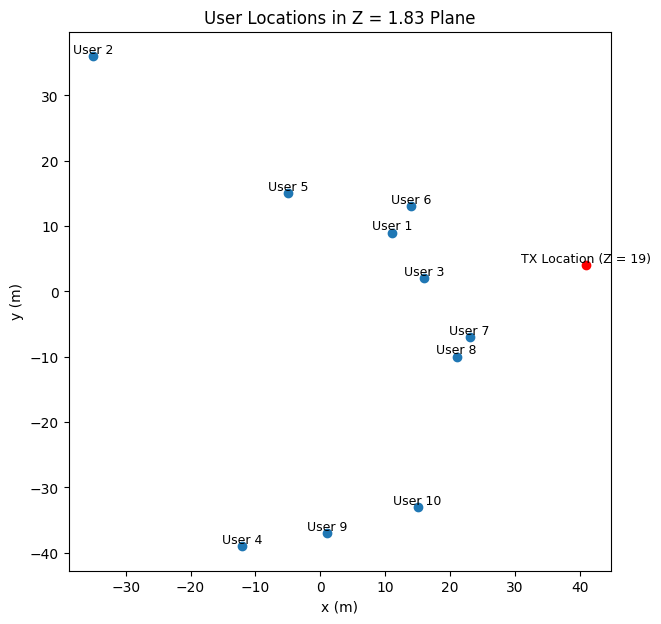

In [13]:
user_positions_3d = np.array(rx_pos)
user_positions_2d = user_positions_3d[:, :2]
plt.figure(figsize = (7,7))
plt.scatter(user_positions_2d[:, 0], user_positions_2d[:, 1])
plt.scatter(TX_LOC[0], TX_LOC[1], c='red')
plt.text(TX_LOC[0], TX_LOC[1], "TX Location (Z = 19)", fontsize = 9, ha = 'center', va = 'bottom')
for i, (x,y) in enumerate(user_positions_2d):
    plt.text(x, y, f"User {i + 1}", fontsize = 9, ha = 'center', va = 'bottom')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(f"User Locations in Z = {UE_Z} Plane")

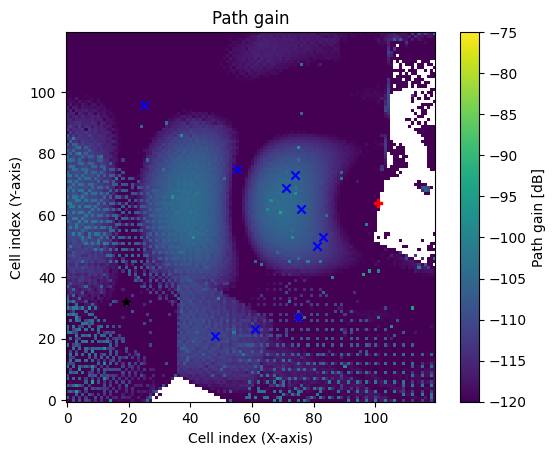

In [14]:
cm_no = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10**6,
                        cm_orientation=[0,0,0],
                        reflection=True,
                        diffraction=True,
                        cm_center=[0,0,UE_Z],
                        cm_size=[120,120],
                        ris = False,
                        cm_cell_size=[1, 1])
no_ris = cm_no.show(vmin=-120, vmax=-75, show_ris=True, show_tx=True, show_rx=True)


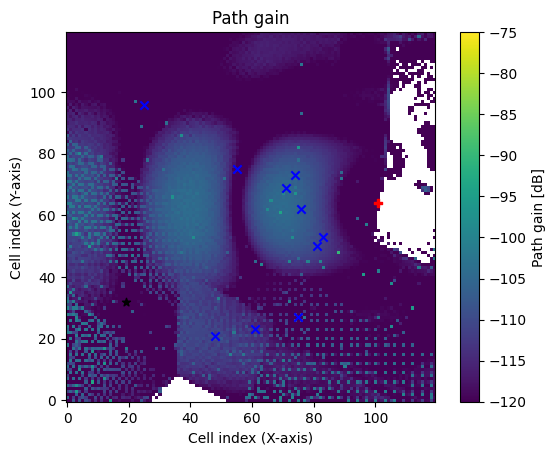

In [15]:
cm_yes = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10**6,
                        cm_orientation=[0,0,0],
                        reflection=True,
                        diffraction=True,
                        cm_center=[0,0,UE_Z],
                        cm_size=[120,120],
                        ris = True,
                        cm_cell_size=[1, 1])
yes_ris = cm_yes.show(vmin=-120, vmax=-75, show_ris=True, show_tx=True, show_rx=True)

/tmp/ipykernel_10008/3043366172.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cm_yes.path_gain[0]/cm_no.path_gain[0]), origin='lower', vmin=0)


Text(0.5, 1.0, 'RIS Coverage Gain')

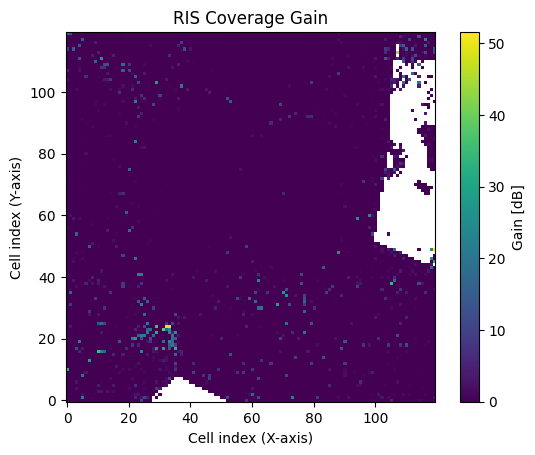

In [16]:
fig = plt.figure()
plt.imshow(10*np.log10(cm_yes.path_gain[0]/cm_no.path_gain[0]), origin='lower', vmin=0)
plt.colorbar(label='Gain [dB]')
plt.xlabel('Cell index (X-axis)')
plt.ylabel('Cell index (Y-axis)')
plt.title("RIS Coverage Gain")

/tmp/ipykernel_10008/2803593378.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cm_yes.sinr[0]/cm_no.sinr[0]), origin='lower', vmin=0)


Text(0.5, 1.0, 'RIS SINR Enhancement')

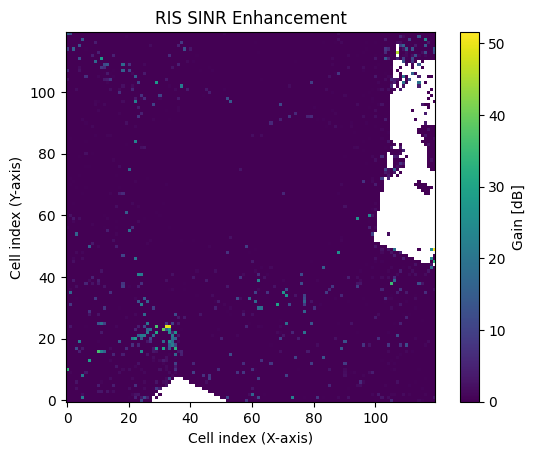

In [17]:
fig = plt.figure()
plt.imshow(10*np.log10(cm_yes.sinr[0]/cm_no.sinr[0]), origin='lower', vmin=0)
plt.colorbar(label='Gain [dB]')
plt.xlabel('Cell index (X-axis)')
plt.ylabel('Cell index (Y-axis)')
plt.title("RIS SINR Enhancement")

/tmp/ipykernel_10008/1907107460.py:4: RuntimeWarning: divide by zero encountered in divide
  cap_diff = cap_yes / cap_no
/tmp/ipykernel_10008/1907107460.py:4: RuntimeWarning: invalid value encountered in divide
  cap_diff = cap_yes / cap_no


Text(0.5, 1.0, 'RIS Capacity Enhancement')

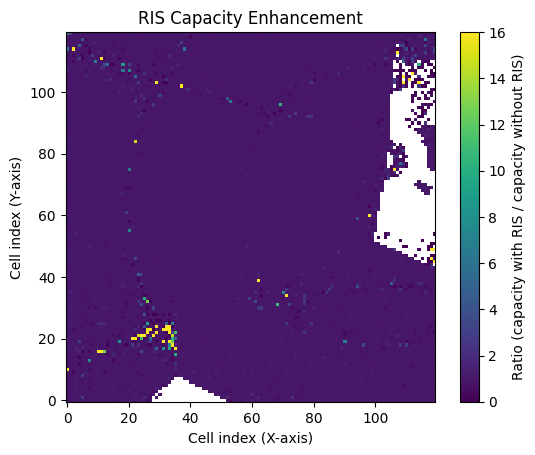

In [18]:
fig = plt.figure()
cap_yes = np.log2(1 + cm_yes.sinr[0])
cap_no = np.log2(1 + cm_no.sinr[0])
cap_diff = cap_yes / cap_no
nzmin_no = cap_no[cap_no >= 1].min()
plt.imshow(cap_diff, origin='lower', vmin=0, vmax = int(np.max(cap_yes) / nzmin_no))
plt.colorbar(label='Ratio (capacity with RIS / capacity without RIS)')
plt.xlabel('Cell index (X-axis)')
plt.ylabel('Cell index (Y-axis)')
plt.title("RIS Capacity Enhancement")